# Sentanyl (Capstone)


In [1]:
# import libraries we'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf

## Data exploration

### Mount Google drive to load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Load data

In [3]:
import os

# Set the search parameters
filename = 'FULL_Capstone_Data.xlsx'
search_path = '/content/drive/My Drive/My_folder_W210_Capstone/'
# Search for the file
file_path = None
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break
df_full = pd.read_excel(file_path)

In [3]:
file_path

'/content/drive/My Drive/My_folder_W210_Capstone/FULL_Capstone_Data.xlsx'

In [4]:
df_full.shape

(11220, 99)

In [231]:
df_full

,county_name,Provisional Drug Overdose Deaths,Overdose_Rate_X100K,PERIOD,ST_ABBREV,Drugs_Offense_Count,BP_Count,BP_Weight,YEAR,POPESTIMATE,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,ALAMEDA,326.0,23.597812,202101,CA,0.0,93,945.066404,2021,1680380,...,22682,27200,11444,15756,31364,10773,20591,38.3,37.6,38.9
1,ALAMEDA,326.0,23.597812,202102,CA,0.0,118,796.762695,2021,1680380,...,22682,27200,11444,15756,31364,10773,20591,38.3,37.6,38.9
2,ALAMEDA,336.0,24.321671,202103,CA,0.0,145,651.891995,2021,1680380,...,22682,27200,11444,15756,31364,10773,20591,38.3,37.6,38.9
3,ALAMEDA,336.0,24.321671,202104,CA,0.0,140,886.411292,2021,1680380,...,22682,27200,11444,15756,31364,10773,20591,38.3,37.6,38.9
4,ALAMEDA,338.0,24.466443,202105,CA,0.0,135,949.615541,2021,1680380,...,22682,27200,11444,15756,31364,10773,20591,38.3,37.6,38.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11215,ZAVALA,NaN,NaN,202302,TX,NaN,118,2293.297218,2023,9377,...,156,144,59,85,113,56,57,32.5,31.4,33.7
11216,ZAVALA,NaN,NaN,202303,TX,NaN,144,2853.646426,2023,9377,...,156,144,59,85,113,56,57,32.5,31.4,33.7
11217,ZAVALA,NaN,NaN,202304,TX,NaN,132,3220.316293,2023,9377,...,156,144,59,85,113,56,57,32.5,31.4,33.7
11218,ZAVALA,NaN,NaN,202305,TX,NaN,140,2683.455575,2023,9377,...,156,144,59,85,113,56,57,32.5,31.4,33.7


### Preliminary EDA to find high-priority counties, states

In [5]:
df_full['county_name'].nunique()

364

In [6]:
df_full['Overdose_Rate_X100K'].mean()

23.239314863566637

In [15]:
df_full['Overdose_Rate_X100K'].describe()

count    6653.000000
mean       23.239315
std        20.567120
min         0.000000
25%         0.000000
50%        23.692362
75%        34.526838
max       135.838805
Name: Overdose_Rate_X100K, dtype: float64

There are many rows with rates to 0; let's filter out data to include only counties with higher than average rates and relatively high monthly rates for all samples

For example, let's filter to counties for which rates are always

In [7]:
df_eda = df_full.copy()

In [20]:
pivot = df_eda.pivot_table('Overdose_Rate_X100K','county_name',aggfunc='mean').reset_index()
pivot

,county_name,Overdose_Rate_X100K
0,ALAMEDA,24.558196
1,ALBANY,36.422967
2,ALLEGANY,37.975844
3,ALPINE,0.000000
4,AMADOR,30.763231
...,...,...
304,WOOD,28.338867
305,WYOMING,31.921976
306,YOLO,20.592854
307,YUBA,46.852319


In [21]:
pivot.sort_values('Overdose_Rate_X100K',axis=0,ascending=False)

,county_name,Overdose_Rate_X100K
149,LAKE,109.947934
178,MENDOCINO,84.490393
68,DEL NORTE,82.253978
128,INYO,80.526157
266,SULLIVAN,74.895880
...,...,...
140,KENT,0.000000
143,KIMBLE,0.000000
144,KING,0.000000
146,KINNEY,0.000000


In [73]:
# convert nan rates to 0
df_eda['Overdose_Rate_X100K'] = df_eda['Overdose_Rate_X100K'].replace(np.nan, 0)


In [74]:
df_min = df_eda.groupby('county_name')['Overdose_Rate_X100K'].min().to_frame().reset_index()
df_min

,county_name,Overdose_Rate_X100K
0,ALAMEDA,23.028091
1,ALBANY,31.873236
2,ALLEGANY,0.000000
3,ALPINE,0.000000
4,AMADOR,0.000000
...,...,...
359,YOLO,17.498504
360,YOUNG,0.000000
361,YUBA,34.873030
362,ZAPATA,0.000000


In [75]:
# filter those with min values above a certain threshold
thr = 5
df_min_th = df_min[df_min['Overdose_Rate_X100K']> 5]
df_min_th

,county_name,Overdose_Rate_X100K
0,ALAMEDA,23.028091
1,ALBANY,31.873236
7,ANGELINA,16.450320
18,BELL,16.062537
19,BEXAR,18.832055
...,...,...
345,WESTCHESTER,21.543314
348,WICHITA,19.356774
351,WILLIAMSON,9.570971
359,YOLO,17.498504


In [76]:
list_min = list(df_min_th['county_name'])
len(list_min)

117

In [77]:
'PALO PINTO' in str(list_min)

False

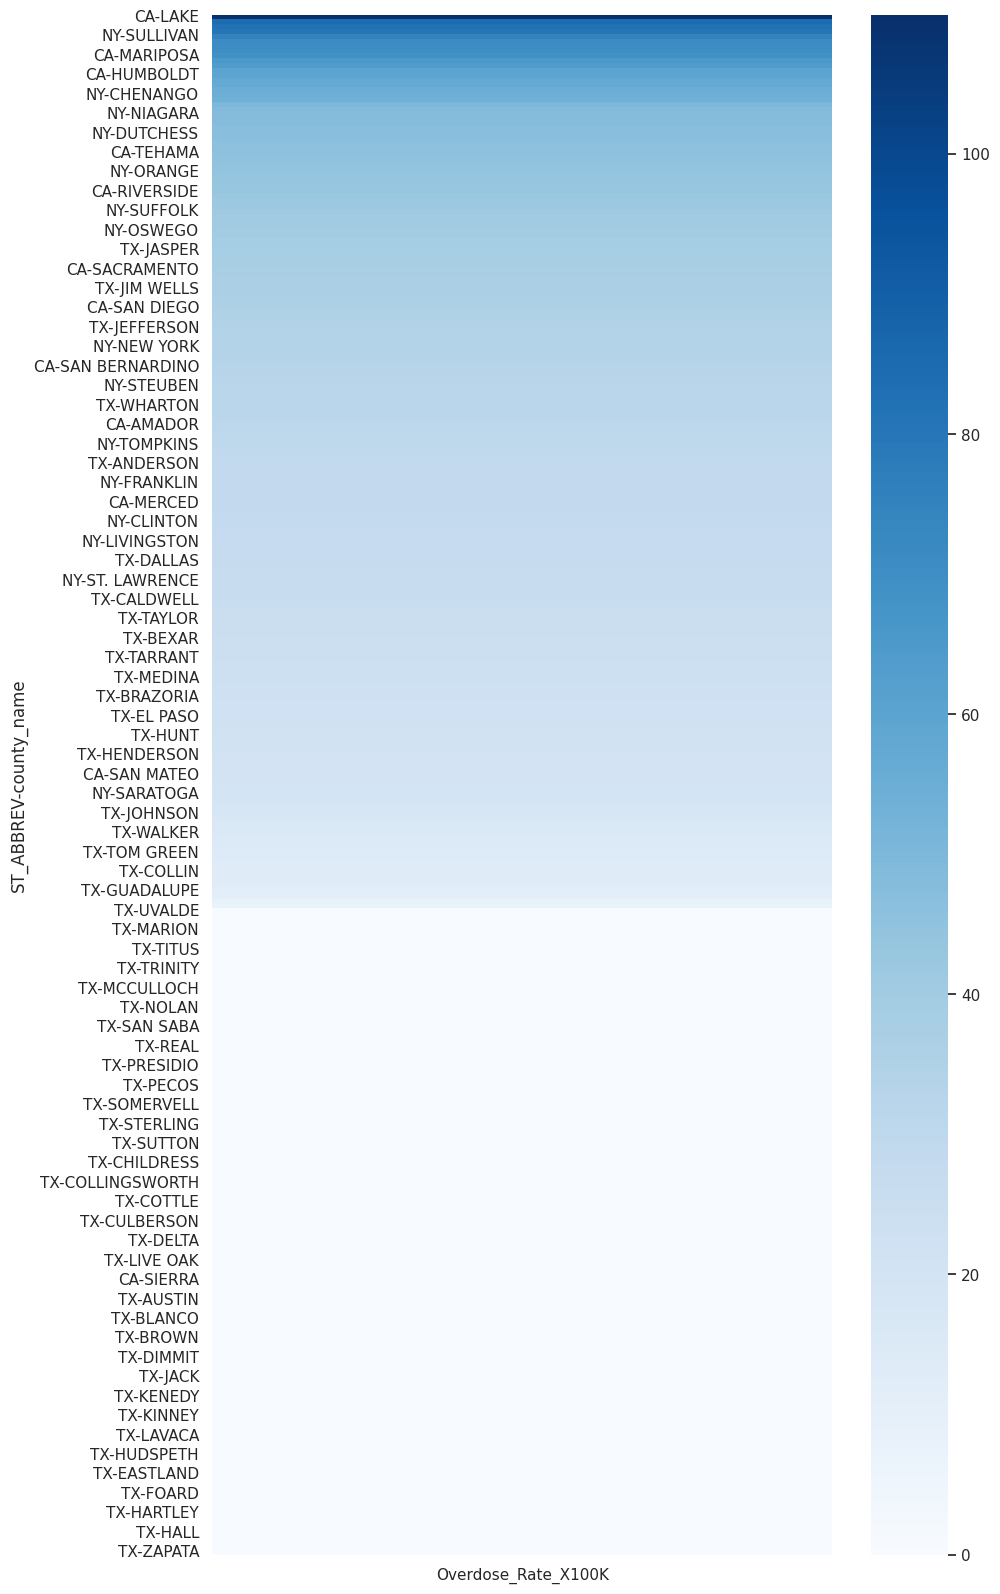

In [23]:
# heatmap visual
pivot = df_eda.pivot_table(index=['ST_ABBREV','county_name'],values=['Overdose_Rate_X100K'],aggfunc='mean').sort_values(by=['Overdose_Rate_X100K'],ascending=False)
fig,ax=plt.subplots(figsize=(10,20))
sns.heatmap(pivot,cmap="Blues",ax=ax)
plt.show()

In [24]:
top_counties_tuples = pivot.head(50).index.values.tolist()
top_counties = list(zip(*top_counties_tuples))[1]
top_counties

('LAKE',
 'MENDOCINO',
 'DEL NORTE',
 'INYO',
 'SULLIVAN',
 'SAN FRANCISCO',
 'BRONX',
 'KERN',
 'MARIPOSA',
 'HUTCHINSON',
 'BUTTE',
 'LASSEN',
 'HUMBOLDT',
 'CHAUTAUQUA',
 'GLENN',
 'BROOME',
 'CHENANGO',
 'LAMPASAS',
 'CHEMUNG',
 'ARANSAS',
 'NIAGARA',
 'SISKIYOU',
 'ULSTER',
 'GREENE',
 'DUTCHESS',
 'YUBA',
 'SHASTA',
 'ONONDAGA',
 'TEHAMA',
 'HILL',
 'SAN LUIS OBISPO',
 'ORANGE',
 'ORANGE',
 'PALO PINTO',
 'MONROE',
 'NEVADA',
 'RIVERSIDE',
 'ONEIDA',
 'CATTARAUGUS',
 'ERIE',
 'SUFFOLK',
 'CHAMBERS',
 'RICHMOND',
 'SCHOHARIE',
 'OSWEGO',
 'SUTTER',
 'ESSEX',
 'STANISLAUS',
 'JASPER',
 'FULTON')

In [78]:
# we merge both lists; we keep only counties that are in both lists
top_counties = [item for item in list_min if item in top_counties]
len(top_counties)

32

In [79]:
if 'PALO PINTO' in str(top_counties):
  print("in list")
else:
  print("not in list")

not in list


### Filter to desired counties, all states

In [93]:
# filter to ALAMEDA
# test_county = 'ALAMEDA'
# df_ala = df_full.loc[df['county_name'] == test_county]

# filter to states or counties, example counties
counties_list = top_counties
# df = df_full.loc[df['county_name'] == test_county]
# or
df_top = df_full[df_full['county_name'].isin(counties_list)]

# mask = df_full['county_name'].isin(counties_list)
# df_top = df_full[mask]



In [94]:
# all states and counties
df = df_top.copy()
df

,county_name,Provisional Drug Overdose Deaths,Overdose_Rate_X100K,PERIOD,ST_ABBREV,Drugs_Offense_Count,BP_Count,BP_Weight,YEAR,POPESTIMATE,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
90,BUTTE,79.0,45.765530,202101,CA,0.0,93,945.066404,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
91,BUTTE,83.0,48.082772,202102,CA,0.0,118,796.762695,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
92,BUTTE,90.0,52.137945,202103,CA,0.0,145,651.891995,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
93,BUTTE,99.0,57.351740,202104,CA,0.0,140,886.411292,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
94,BUTTE,104.0,60.248292,202105,CA,0.0,135,949.615541,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9025,ORANGE,32.0,48.507632,202301,TX,NaN,98,1445.472428,2023,84934,...,1410,1531,645,886,1438,531,907,37.5,36.7,38.3
9026,ORANGE,33.0,50.023496,202303,TX,NaN,144,2853.646426,2023,84934,...,1410,1531,645,886,1438,531,907,37.5,36.7,38.3
9027,ORANGE,28.0,42.511843,202211,TX,12.0,106,1116.009141,2022,84641,...,1332,1573,645,928,1429,523,906,37.7,36.9,38.6
9028,ORANGE,29.0,44.030123,202212,TX,20.0,81,549.237488,2022,84641,...,1332,1573,645,928,1429,523,906,37.7,36.9,38.6


In [95]:
df.dtypes

county_name                          object
Provisional Drug Overdose Deaths    float64
Overdose_Rate_X100K                 float64
PERIOD                                int64
ST_ABBREV                            object
                                     ...   
AGE85PLUS_MALE                        int64
AGE85PLUS_FEM                         int64
MEDIAN_AGE_TOT                      float64
MEDIAN_AGE_MALE                     float64
MEDIAN_AGE_FEM                      float64
Length: 99, dtype: object

In [96]:
# we need to convert PERIOD from int64 to datetime so we can better visualize
df['PERIOD'] = pd.to_datetime(df['PERIOD'],format = '%Y%m').dt.to_period('M')
df

,county_name,Provisional Drug Overdose Deaths,Overdose_Rate_X100K,PERIOD,ST_ABBREV,Drugs_Offense_Count,BP_Count,BP_Weight,YEAR,POPESTIMATE,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
90,BUTTE,79.0,45.765530,2021-01,CA,0.0,93,945.066404,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
91,BUTTE,83.0,48.082772,2021-02,CA,0.0,118,796.762695,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
92,BUTTE,90.0,52.137945,2021-03,CA,0.0,145,651.891995,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
93,BUTTE,99.0,57.351740,2021-04,CA,0.0,140,886.411292,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
94,BUTTE,104.0,60.248292,2021-05,CA,0.0,135,949.615541,2021,210135,...,3465,4096,1789,2307,4521,1553,2968,36.5,35.5,37.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9025,ORANGE,32.0,48.507632,2023-01,TX,NaN,98,1445.472428,2023,84934,...,1410,1531,645,886,1438,531,907,37.5,36.7,38.3
9026,ORANGE,33.0,50.023496,2023-03,TX,NaN,144,2853.646426,2023,84934,...,1410,1531,645,886,1438,531,907,37.5,36.7,38.3
9027,ORANGE,28.0,42.511843,2022-11,TX,12.0,106,1116.009141,2022,84641,...,1332,1573,645,928,1429,523,906,37.7,36.9,38.6
9028,ORANGE,29.0,44.030123,2022-12,TX,20.0,81,549.237488,2022,84641,...,1332,1573,645,928,1429,523,906,37.7,36.9,38.6


In [97]:
# sort df by date within each group

df.sort_values(['county_name', 'PERIOD'], ascending=[True, True], inplace=True, ignore_index=True)


In [98]:
df

,county_name,Provisional Drug Overdose Deaths,Overdose_Rate_X100K,PERIOD,ST_ABBREV,Drugs_Offense_Count,BP_Count,BP_Weight,YEAR,POPESTIMATE,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,BRONX,603.0,52.969079,2021-01,NY,NaN,93,945.066404,2021,1461125,...,20724,23352,8440,14912,25245,7270,17975,34.8,32.9,36.7
1,BRONX,612.0,53.759663,2021-02,NY,NaN,118,796.762695,2021,1461125,...,20724,23352,8440,14912,25245,7270,17975,34.8,32.9,36.7
2,BRONX,625.0,54.901616,2021-03,NY,NaN,145,651.891995,2021,1461125,...,20724,23352,8440,14912,25245,7270,17975,34.8,32.9,36.7
3,BRONX,659.0,57.888264,2021-04,NY,NaN,140,886.411292,2021,1461125,...,20724,23352,8440,14912,25245,7270,17975,34.8,32.9,36.7
4,BRONX,666.0,58.503162,2021-05,NY,NaN,135,949.615541,2021,1461125,...,20724,23352,8440,14912,25245,7270,17975,34.8,32.9,36.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,YUBA,41.0,64.115596,2023-02,CA,NaN,118,2293.297218,2023,84310,...,1081,1234,568,666,977,421,556,33.9,33.2,34.6
1016,YUBA,42.0,65.679391,2023-03,CA,NaN,144,2853.646426,2023,84310,...,1081,1234,568,666,977,421,556,33.9,33.2,34.6
1017,YUBA,39.0,60.988006,2023-04,CA,NaN,132,3220.316293,2023,84310,...,1081,1234,568,666,977,421,556,33.9,33.2,34.6
1018,YUBA,39.0,60.988006,2023-05,CA,NaN,140,2683.455575,2023,84310,...,1081,1234,568,666,977,421,556,33.9,33.2,34.6


### Feature selection
For the first baseline tests, we will keep just a few of the 99 columns.
The values come as numbers,so no need to convert to floats.
Also, we remove examples (rows) that have some missing value(s) of the columns we care about.
We also build some features as functions of columns.

Create ChangeInRate feature, but we'll need to remove rows for 1st months '2021-01'

In [99]:
df['previousRate'] = df['Overdose_Rate_X100K'].shift(1)
df['nextRate'] = df['Overdose_Rate_X100K'].shift(-1)
df['changePrior'] = df['Overdose_Rate_X100K'] - df['previousRate']
df['predChange'] = df['nextRate'] - df['Overdose_Rate_X100K']

In [100]:
df

,county_name,Provisional Drug Overdose Deaths,Overdose_Rate_X100K,PERIOD,ST_ABBREV,Drugs_Offense_Count,BP_Count,BP_Weight,YEAR,POPESTIMATE,...,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,previousRate,nextRate,changePrior,predChange
0,BRONX,603.0,52.969079,2021-01,NY,NaN,93,945.066404,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,NaN,53.759663,NaN,0.790583
1,BRONX,612.0,53.759663,2021-02,NY,NaN,118,796.762695,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,52.969079,54.901616,0.790583,1.141954
2,BRONX,625.0,54.901616,2021-03,NY,NaN,145,651.891995,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,53.759663,57.888264,1.141954,2.986648
3,BRONX,659.0,57.888264,2021-04,NY,NaN,140,886.411292,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,54.901616,58.503162,2.986648,0.614898
4,BRONX,666.0,58.503162,2021-05,NY,NaN,135,949.615541,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,57.888264,61.665495,0.614898,3.162333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,YUBA,41.0,64.115596,2023-02,CA,NaN,118,2293.297218,2023,84310,...,977,421,556,33.9,33.2,34.6,65.679391,65.679391,-1.563795,1.563795
1016,YUBA,42.0,65.679391,2023-03,CA,NaN,144,2853.646426,2023,84310,...,977,421,556,33.9,33.2,34.6,64.115596,60.988006,1.563795,-4.691385
1017,YUBA,39.0,60.988006,2023-04,CA,NaN,132,3220.316293,2023,84310,...,977,421,556,33.9,33.2,34.6,65.679391,60.988006,-4.691385,0.000000
1018,YUBA,39.0,60.988006,2023-05,CA,NaN,140,2683.455575,2023,84310,...,977,421,556,33.9,33.2,34.6,60.988006,57.860416,0.000000,-3.127590


In [101]:
# drop rows with 'PERIOD' to '2021-01' or '2023-06' as bookends
df.drop(df[df.PERIOD == '2021-01'].index, inplace=True)
df.drop(df[df.PERIOD == '2023-06'].index, inplace=True)

In [102]:
df

,county_name,Provisional Drug Overdose Deaths,Overdose_Rate_X100K,PERIOD,ST_ABBREV,Drugs_Offense_Count,BP_Count,BP_Weight,YEAR,POPESTIMATE,...,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,previousRate,nextRate,changePrior,predChange
1,BRONX,612.0,53.759663,2021-02,NY,NaN,118,796.762695,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,52.969079,54.901616,0.790583,1.141954
2,BRONX,625.0,54.901616,2021-03,NY,NaN,145,651.891995,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,53.759663,57.888264,1.141954,2.986648
3,BRONX,659.0,57.888264,2021-04,NY,NaN,140,886.411292,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,54.901616,58.503162,2.986648,0.614898
4,BRONX,666.0,58.503162,2021-05,NY,NaN,135,949.615541,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,57.888264,61.665495,0.614898,3.162333
5,BRONX,702.0,61.665495,2021-06,NY,NaN,110,1056.409906,2021,1461125,...,25245,7270,17975,34.8,32.9,36.7,58.503162,61.050597,3.162333,-0.614898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,YUBA,42.0,65.679391,2023-01,CA,NaN,98,1445.472428,2023,84310,...,977,421,556,33.9,33.2,34.6,61.820372,64.115596,3.859019,-1.563795
1015,YUBA,41.0,64.115596,2023-02,CA,NaN,118,2293.297218,2023,84310,...,977,421,556,33.9,33.2,34.6,65.679391,65.679391,-1.563795,1.563795
1016,YUBA,42.0,65.679391,2023-03,CA,NaN,144,2853.646426,2023,84310,...,977,421,556,33.9,33.2,34.6,64.115596,60.988006,1.563795,-4.691385
1017,YUBA,39.0,60.988006,2023-04,CA,NaN,132,3220.316293,2023,84310,...,977,421,556,33.9,33.2,34.6,65.679391,60.988006,-4.691385,0.000000


In [103]:
pd.isnull(df).sum()[pd.isnull(df).sum() > 0]

Drugs_Offense_Count    331
dtype: int64

In [104]:
# df[df['Drugs_Offense_Count'].isna()]
# df[df['Overdose_Rate_X100K'].isna()]

In [105]:
# df1 = df[df.isna().any(axis=1)]

# df1

#### Create new features from existing ones

% male population, % population 25-64

In [106]:
# df_ala['age_'] = df[['colA','colB']].prod(1).where(df['colC']>0, df['colA'] / df['colB'])
df['male_pct'] = df['POPEST_MALE'] / df['POPESTIMATE']
df['ages25_64_pct'] = ( df['AGE4564_TOT'] + df['AGE2544_TOT'] ) / df['POPESTIMATE']


In [107]:
df.columns

Index(['county_name', 'Provisional Drug Overdose Deaths',
       'Overdose_Rate_X100K', 'PERIOD', 'ST_ABBREV', 'Drugs_Offense_Count',
       'BP_Count', 'BP_Weight', 'YEAR', 'POPESTIMATE',
       ...
       'AGE85PLUS_FEM', 'MEDIAN_AGE_TOT', 'MEDIAN_AGE_MALE', 'MEDIAN_AGE_FEM',
       'previousRate', 'nextRate', 'changePrior', 'predChange', 'male_pct',
       'ages25_64_pct'],
      dtype='object', length=105)

In [108]:
# Choose a subset of columns
columns = [ 'county_name', 'Overdose_Rate_X100K', 'PERIOD', 'Drugs_Offense_Count', 'BP_Count', 'BP_Weight', 'previousRate', 'nextRate', 'changePrior', 'predChange', 'male_pct',
       'ages25_64_pct']
df = df[columns]

# Convert strings to numeric values, coercing missing values to nan.
# for column in columns:
#   df_ala[column] = pd.to_numeric(df_ala[column], errors='coerce')



In [109]:
df

,county_name,Overdose_Rate_X100K,PERIOD,Drugs_Offense_Count,BP_Count,BP_Weight,previousRate,nextRate,changePrior,predChange,male_pct,ages25_64_pct
1,BRONX,53.759663,2021-02,NaN,118,796.762695,52.969079,54.901616,0.790583,1.141954,0.474076,0.522397
2,BRONX,54.901616,2021-03,NaN,145,651.891995,53.759663,57.888264,1.141954,2.986648,0.474076,0.522397
3,BRONX,57.888264,2021-04,NaN,140,886.411292,54.901616,58.503162,2.986648,0.614898,0.474076,0.522397
4,BRONX,58.503162,2021-05,NaN,135,949.615541,57.888264,61.665495,0.614898,3.162333,0.474076,0.522397
5,BRONX,61.665495,2021-06,NaN,110,1056.409906,58.503162,61.050597,3.162333,-0.614898,0.474076,0.522397
...,...,...,...,...,...,...,...,...,...,...,...,...
1014,YUBA,65.679391,2023-01,NaN,98,1445.472428,61.820372,64.115596,3.859019,-1.563795,0.510224,0.502598
1015,YUBA,64.115596,2023-02,NaN,118,2293.297218,65.679391,65.679391,-1.563795,1.563795,0.510224,0.502598
1016,YUBA,65.679391,2023-03,NaN,144,2853.646426,64.115596,60.988006,1.563795,-4.691385,0.510224,0.502598
1017,YUBA,60.988006,2023-04,NaN,132,3220.316293,65.679391,60.988006,-4.691385,0.000000,0.510224,0.502598


In [110]:
df.shape

(952, 12)

In [111]:
df['PERIOD'].unique()

<PeriodArray>
['2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
 '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
 '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
 '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05']
Length: 28, dtype: period[M]

### Train/Test split

In [112]:
df.shape

(952, 12)

In [113]:
df.head()

,county_name,Overdose_Rate_X100K,PERIOD,Drugs_Offense_Count,BP_Count,BP_Weight,previousRate,nextRate,changePrior,predChange,male_pct,ages25_64_pct
1,BRONX,53.759663,2021-02,NaN,118,796.762695,52.969079,54.901616,0.790583,1.141954,0.474076,0.522397
2,BRONX,54.901616,2021-03,NaN,145,651.891995,53.759663,57.888264,1.141954,2.986648,0.474076,0.522397
3,BRONX,57.888264,2021-04,NaN,140,886.411292,54.901616,58.503162,2.986648,0.614898,0.474076,0.522397
4,BRONX,58.503162,2021-05,NaN,135,949.615541,57.888264,61.665495,0.614898,3.162333,0.474076,0.522397
5,BRONX,61.665495,2021-06,NaN,110,1056.409906,58.503162,61.050597,3.162333,-0.614898,0.474076,0.522397


In [114]:
# We'll use these input features.
features = ['BP_Count', 'BP_Weight', 'changePrior', 'male_pct', 'ages25_64_pct']

# Use a ~80/20 train/test split.
df_train = df[:int(0.8*df.shape[0])]
df_test = df[int(0.8*df.shape[0]):]

# df_train = (df.loc[df['PERIOD'].isin(['2023-01','2023-02', '2023-03','2023-04', '2023-05','2023-06']) == False])
# df_test = (df.loc[df['PERIOD'].isin(['2023-01','2023-02', '2023-03','2023-04', '2023-05','2023-06'])])


# Create separate variables for features (inputs) and labels (outputs).
# We will be using these in the cells below.
df_train_features = df_train[features]
df_test_features = df_test[features]
df_train_labels = df_train['predChange']
df_test_labels = df_test['predChange']

# Confirm the data shapes are as expected.
print('train data shape:', df_train_features.shape)
print('train labels shape:', df_train_labels.shape)
print('test data shape:', df_test_features.shape)
print('test labels shape:', df_test_labels.shape)

train data shape: (761, 5)
train labels shape: (761,)
test data shape: (191, 5)
test labels shape: (191,)


In [115]:
df_train_features

,BP_Count,BP_Weight,changePrior,male_pct,ages25_64_pct
1,118,796.762695,0.790583,0.474076,0.522397
2,145,651.891995,1.141954,0.474076,0.522397
3,140,886.411292,2.986648,0.474076,0.522397
4,135,949.615541,0.614898,0.474076,0.522397
5,110,1056.409906,3.162333,0.474076,0.522397
...,...,...,...,...,...
811,118,796.762695,1.358769,0.494692,0.498258
812,145,651.891995,3.396924,0.494692,0.498258
813,140,886.411292,-0.679385,0.494692,0.498258
814,135,949.615541,-1.358769,0.494692,0.498258


### Baseline

In [116]:
df_train_labels

1      1.141954
2      2.986648
3      0.614898
4      3.162333
5     -0.614898
         ...   
811    3.396924
812   -0.679385
813   -1.358769
814    0.679385
815    3.396924
Name: predChange, Length: 761, dtype: float64

In [117]:
np.average(df_train_labels)

0.4010012649558141

In [119]:
baseline = np.average(df_train_labels)
# Baseline model: f(x) = baseline
df_train['yhat'] = baseline
diff_train = df_train['yhat'] - df_train['predChange']
print(
    'RMSE train baseline model:', np.sqrt(np.sum(diff_train**2) / df_train.shape[0])
    )
df_test['yhat'] = baseline
diff_test = df_test['yhat'] - df_test['predChange']
print(
    'RMSE test baseline model:', np.sqrt(np.sum(diff_test**2) / df_test.shape[0])
    )

RMSE train baseline model: 4.566422847816603
RMSE test baseline model: 3.041379880355042


<ipython-input-119-c891525cdfd8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['yhat'] = baseline
<ipython-input-119-c891525cdfd8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['yhat'] = baseline


In [74]:
df_train

,county_name,Overdose_Rate_X100K,PERIOD,Drugs_Offense_Count,BP_Count,BP_Weight,male_pct,ages25_64_pct,ChangeInRate,yhat
3118,SARATOGA,26.053906,2021-02,4.0,118.0,796.762695,0.497477,0.534187,5.619470,-0.001027
1168,SAN JOAQUIN,29.797524,2023-01,NaN,98.0,1445.472428,0.501532,0.507198,-1.637227,-0.001027
1952,CHEMUNG,43.851956,2021-03,NaN,145.0,651.891995,0.498707,0.509965,4.385196,-0.001027
2386,HERKIMER,34.387200,2022-11,0.0,106.0,1116.009141,0.500333,0.498868,14.101990,-0.001027
2938,PUTNAM,19.535304,2023-05,NaN,140.0,2683.455575,0.502871,0.535805,-3.662869,-0.001027
...,...,...,...,...,...,...,...,...,...,...
190,CONTRA COSTA,26.583160,2022-10,206.0,119.0,1050.510483,0.492957,0.530686,-1.222909,-0.001027
3927,BASTROP,18.412815,2021-06,42.0,110.0,1056.409906,0.511709,0.501805,-2.630402,-0.001027
5148,CRANE,0.000000,2022-07,3.0,145.0,2159.849703,0.508299,0.487605,0.000000,-0.001027
1630,TUOLUMNE,38.898734,2023-04,NaN,132.0,3220.316293,0.514680,0.482423,2.710812,-0.001027


### Feature Histograms

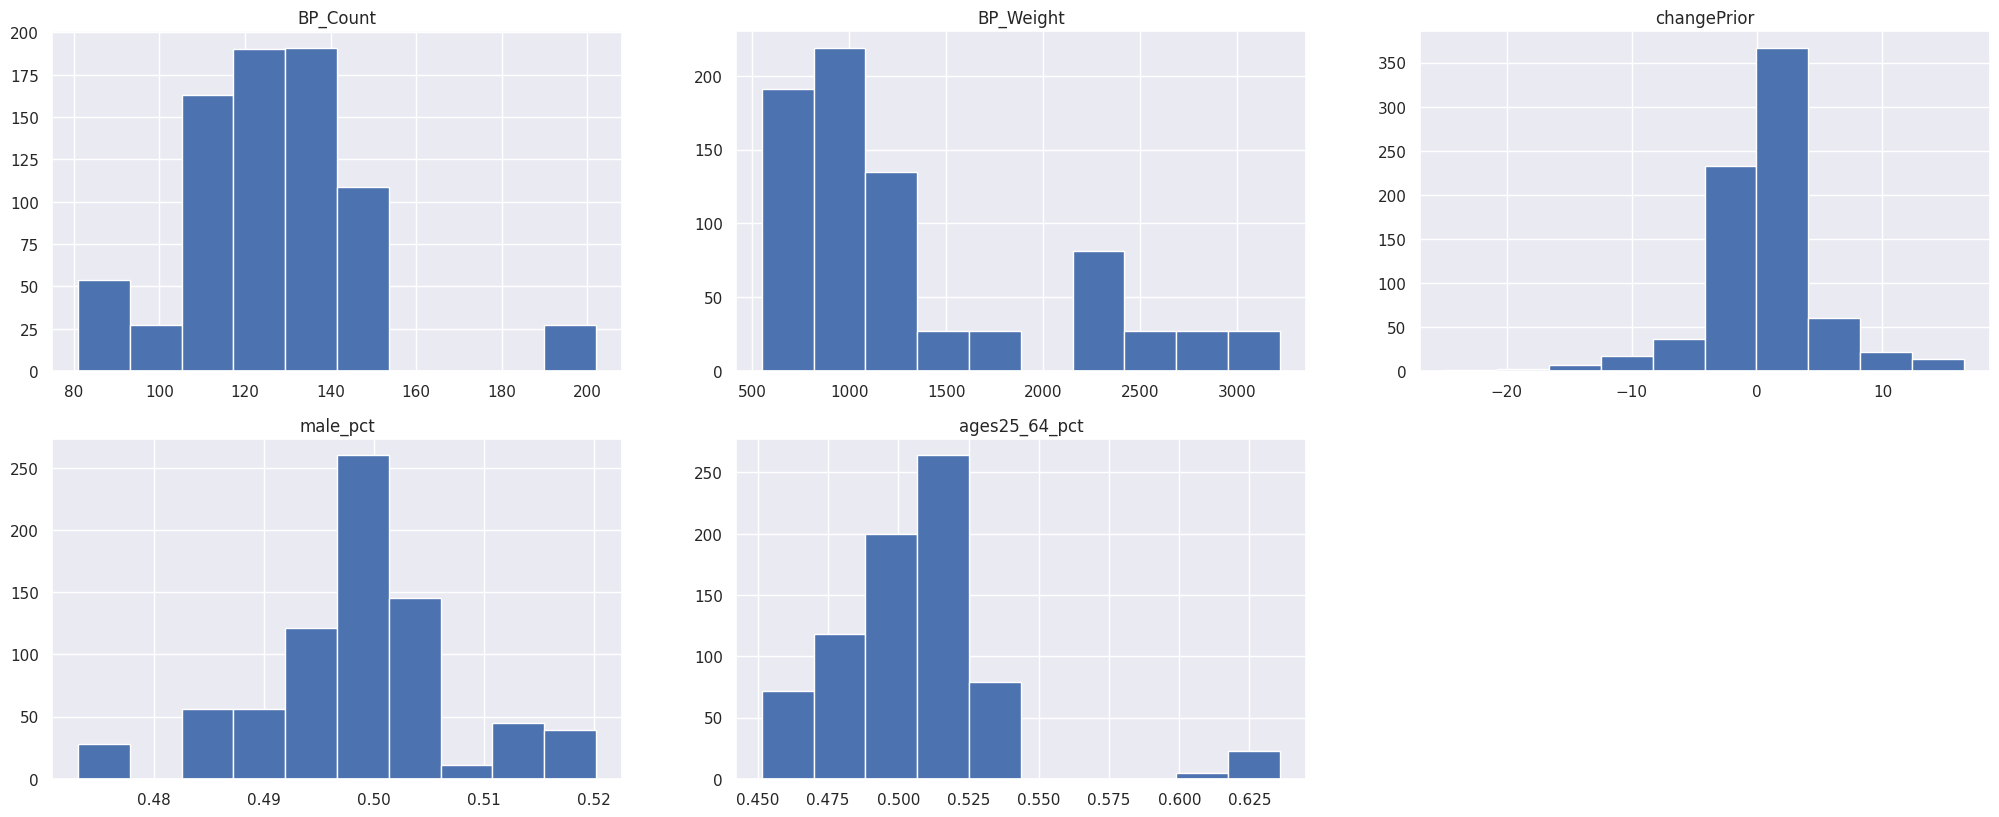

,Overdose_Rate_X100K,Drugs_Offense_Count,BP_Count,BP_Weight,previousRate,nextRate,changePrior,predChange,male_pct,ages25_64_pct,yhat
count,761.000000,488.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,53.232901,38.725410,126.804205,1334.499150,52.782621,53.633902,0.450280,0.401001,0.498496,0.506193,0.401001
std,17.702567,137.253667,22.142892,721.062664,17.581345,17.821069,4.491093,4.569426,0.009041,0.031088,0.000000
min,27.985475,0.000000,81.000000,549.237488,25.793139,28.998115,-24.863664,-24.863664,0.473124,0.451362,0.401001
25%,41.465273,0.000000,114.000000,803.633345,41.331328,41.677134,-1.408296,-1.503986,0.495066,0.489527,0.401001
50%,47.575895,2.000000,127.000000,1056.409906,47.342016,47.908682,0.371333,0.277171,0.498565,0.506465,0.401001
75%,60.261482,26.000000,140.000000,1445.472428,59.762399,61.090854,2.283679,2.283907,0.502836,0.518515,0.401001
max,131.949967,1012.000000,202.000000,3220.316293,131.949967,131.949967,16.477844,16.477844,0.520183,0.635813,0.401001


In [120]:
plt.figure(figsize=(25, 15))
for i in range(len(features)):
  plt.subplot(3, 3, i+1)
  plt.hist(np.array(df_train[features[i]]))
  plt.title(features[i])
plt.show()

display(df_train.describe())

### Feature correlations

Using pandas corr() to print all the pairwise correlation coefficients for the columns (use the training data only)

In [121]:
df_train[columns].corr()

<ipython-input-121-fd6fc37c0970>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train[columns].corr()


,Overdose_Rate_X100K,Drugs_Offense_Count,BP_Count,BP_Weight,previousRate,nextRate,changePrior,predChange,male_pct,ages25_64_pct
Overdose_Rate_X100K,1.000000,-0.122151,-0.013120,0.098706,0.967621,0.966930,0.153748,-0.103041,0.073936,-0.090444
Drugs_Offense_Count,-0.122151,1.000000,-0.017279,0.088503,-0.053674,-0.012559,-0.287483,0.456074,-0.039182,0.119906
BP_Count,-0.013120,-0.017279,1.000000,0.247166,-0.006785,-0.022725,-0.025153,-0.037801,0.001376,0.003074
BP_Weight,0.098706,0.088503,0.247166,1.000000,0.103609,0.088092,-0.016529,-0.038838,-0.015146,-0.052928
previousRate,0.967621,-0.053674,-0.006785,0.103609,1.000000,0.953947,-0.100639,-0.028234,0.068923,-0.052106
nextRate,0.966930,-0.012559,-0.022725,0.088092,0.953947,1.000000,0.076925,0.154050,0.066078,-0.072329
changePrior,0.153748,-0.287483,-0.025153,-0.016529,-0.100639,0.076925,1.000000,-0.295629,0.021618,-0.152522
predChange,-0.103041,0.456074,-0.037801,-0.038838,-0.028234,0.154050,-0.295629,1.000000,-0.028727,0.068303
male_pct,0.073936,-0.039182,0.001376,-0.015146,0.068923,0.066078,0.021618,-0.028727,1.000000,0.150101
ages25_64_pct,-0.090444,0.119906,0.003074,-0.052928,-0.052106,-0.072329,-0.152522,0.068303,0.150101,1.000000


Interpretation:

- no two features seem to be redundant (their correlation is close to 1).
- of these features, BP_Count seems to be least helpful in predicting ChangeInRate because their correlation is low (-0.0115)

In [ ]:
# sns.pairplot(df_ala_train[features])

## Tensorflow model

### Build model

In [122]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the MSE loss.
  model.compile(loss='mse', optimizer=optimizer)
  return model

### Train model

### Feature scaling

The scales of features are widely different. We need to normalize.

In [123]:
df_train_features_norm = (df_train_features - df_train_features.mean())/df_train_features.std()
display(df_train_features_norm.describe())

# df_ala_train.iloc[:,0:-1] = df_ala_train.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
# print(df_ala_train)


,BP_Count,BP_Weight,changePrior,male_pct,ages25_64_pct
count,7.610000e+02,7.610000e+02,7.610000e+02,7.610000e+02,7.610000e+02
mean,2.661034e-16,-2.112487e-16,-4.668481e-18,6.965373e-15,2.801088e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.068574e+00,-1.089034e+00,-5.636478e+00,-2.806366e+00,-1.763751e+00
25%,-5.782535e-01,-7.362270e-01,-4.138361e-01,-3.793986e-01,-5.361121e-01
50%,8.842341e-03,-3.856658e-01,-1.757853e-02,7.639900e-03,8.736553e-03
75%,5.959382e-01,1.539024e-01,4.082299e-01,4.800072e-01,3.963622e-01
max,3.395934e+00,2.615330e+00,3.568745e+00,2.398688e+00,4.169476e+00


In [124]:
# For test data, we can't normalize by using mean and variance on test data itself, to preserve purity of test data
df_test_features_norm = (df_test_features - df_train_features.mean())/df_train_features.std()
display(df_test_features_norm.describe())

,BP_Count,BP_Weight,changePrior,male_pct,ages25_64_pct
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,-0.004162,0.021317,-0.040451,0.574894,0.122954
std,1.012135,1.010703,0.683863,0.960016,0.419076
min,-2.068574,-1.089034,-2.189783,-0.465462,-0.375049
25%,-0.600834,-0.689572,-0.448487,-0.188904,-0.255249
50%,-0.036319,-0.352711,-0.047228,0.174040,-0.093690
75%,0.595938,0.723012,0.436101,1.418395,0.641740
max,3.395934,2.615330,2.026633,2.574024,0.831444


### Training with features

Function that plots train and validation set loss

In [125]:
def plot_loss(model, history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(len(history)), history['loss'], marker='.', color='black')
  plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  # Show the final train loss value and the learned model weights.
  print('Final train loss:', list(history['loss'])[-1])
  print('Final validation loss:', list(history['val_loss'])[-1])
  print('Final weights:', model.layers[0].get_weights())

We retrain with the same one feature, but now normalized. We try learning rates [0.0001, 0.001, 0.01, 0.1, 1] after 150 epocchs of training

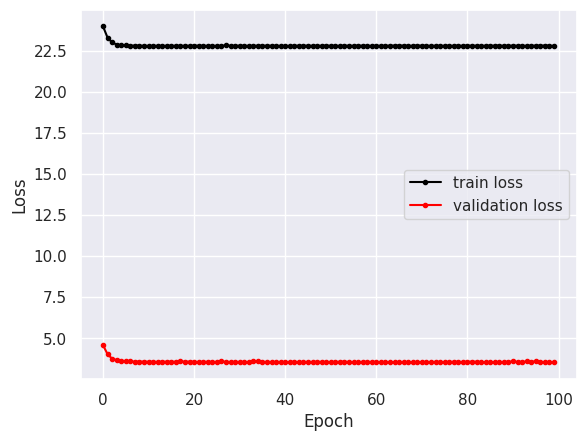

Final train loss: 22.785903930664062
Final validation loss: 3.5444846153259277
Final weights: [array([[-0.16888475]], dtype=float32), array([0.38645518], dtype=float32)]


In [126]:
model = build_model(num_features=1, learning_rate=0.01)

history = model.fit(
  # use the normalized features prepared above
  x = df_train_features_norm[['BP_Count']],
  y = df_train_labels,
  validation_split=0.1,
  epochs=100,
  batch_size=32,
  verbose=0)

plot_loss(model, history)

100 epochs, batch size = 32

lr = 1; final validation loss = 8230.77734375

lr = 0.1; final validation loss = 42.59968185424805

lr = 0.01: final validation loss = 42.5332145690918

lr = 0.001: final validation loss = 42.52028274536133

lr = 0.0001: final validation loss = 42.624473571777344

-----------------------------------------

100 epochs, lr = 0.1,  batch size = 16 --> val_loss = 0.022

-----------------------------------------

100 epochs, lr = 0.1,  batch size = 32 --> val_loss = 0.022


### Adding features

1 features = BP_Count

2 features = BP_Count, BP_Weight

3 features = BP_Count, BP_Weight-rpm, Drugs_Offense_Count

...

For consistency, use a batch size of 32, 100 epochs, and lr = 0.1

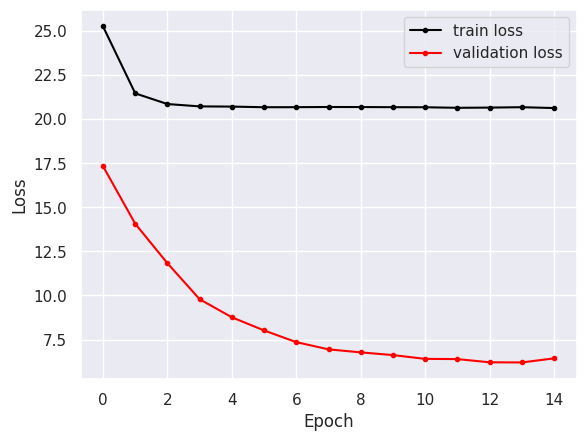

Final train loss: 20.628620147705078
Final validation loss: 6.429906845092773
Final weights: [array([[-0.22451405],
       [-0.21331169],
       [-0.03824944],
       [-1.4334754 ],
       [ 0.45844096]], dtype=float32), array([0.48532423], dtype=float32)]
Test rmse: 3.3208221403449443


In [137]:
def run_experiment(features, learning_rate):
  model = build_model(len(features), learning_rate)

  history = model.fit(
    x = df_train_features_norm[features],
    y = df_train_labels,
    validation_split=0.1,
    epochs=15,
    batch_size=16,
    verbose=0)

  plot_loss(model, history)

  # Make predictions on test data
  test_loss = model.evaluate(df_test_features_norm[features],
                             df_test_labels,
                             verbose=0)
  test_rmse = np.sqrt(test_loss)
  print('Test rmse:', test_rmse)

# features = ['BP_Count']
# features = ['BP_Count', 'BP_Weight']
# features = ['BP_Count', 'BP_Weight', 'Drugs_Offense_Count']
# features = ['BP_Count', 'BP_Weight', 'male_pct']
# features = ['BP_Count', 'BP_Weight', 'male_pct', 'changePrior']
features = ['BP_Count', 'BP_Weight', 'male_pct', 'changePrior', 'ages25_64_pct']


run_experiment(features, 0.01)

Model | Test RMSE
--- | ---
Baseline | 3.04138
BP_Count | 3.05350
  + BP_Weight | 3.03572
  + Drugs_Offense_Count |  ---
  + Male_pct |  3.02087 |
  + changePrior | 3.26537 |
  + ages_25_64_pct | 3.2898

In [162]:
def prediction_plot(testY, test_predict):
  len_prediction=[x for x in range(len(testY))]
  plt.figure(figsize=(8,4))
  plt.plot(len_prediction, testY[:], marker='.', label="actual")
  plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel('Ads Daily Spend', size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show();

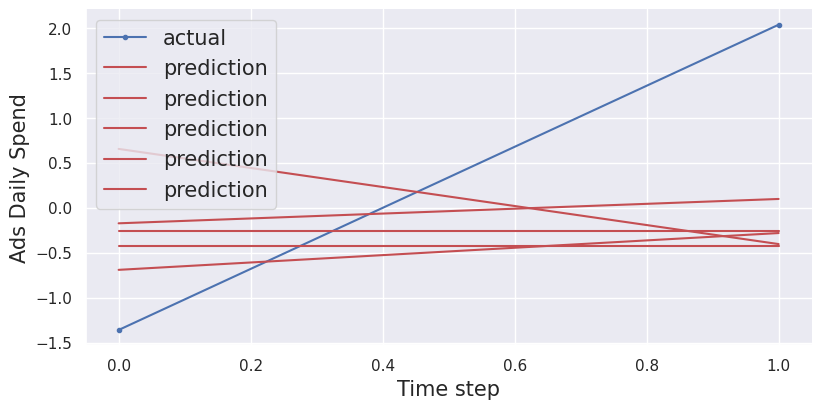

In [163]:
prediction_plot(df_test_labels[:2], df_test_features_norm[:2])

In [154]:
X = np.array([-0.397609, -0.745756, 0.075773, -2.700970,0.521221])
model.predict(X)

1/1 [==============================] - 0s 44ms/step


array([[0.4536053 ],
       [0.512402  ],
       [0.37365827],
       [0.84260786],
       [0.2984289 ]], dtype=float32)